# Exploratory data analysis

1. distribution of marginal features
1. evolution through time of various quantities
1. text information: shop, category, item names

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import random
import re
from nltk.stem.snowball import SnowballStemmer

In [4]:
DATA_FOLDER = '../Data/'
INTERM_RES_FOLDER = "../Intermediary results"

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items    = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cat = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops    = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test     = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

# transform date column and split day - month - year
sales.loc[:, "date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")
sales.loc[:, "day"] = sales["date"].dt.day
sales.loc[:, "month"] = sales["date"].dt.month
sales.loc[:, "year"] = sales["date"].dt.year
# add revenue
sales.loc[:, "item_rev_day"] = sales.loc[:, "item_price"]*sales.loc[:, "item_cnt_day"]

In [6]:
# prepared in 3_preprocess.ipynb
with open(os.path.join(INTERM_RES_FOLDER, "final_project_sets.p"), "rb") as f:
    Xtrain_level1, ytrain_level1, Xtest_level1, months = pickle.load(f)

## 0. Data attributes

In [25]:
print("SALES", sales.shape)
print(sales.columns)

print("\nITEMS", items.shape)
print(items.columns)

print("\nCATEGORIES", item_cat.shape)
print(item_cat.columns)

print("\nSHOPS", shops.shape)
print(shops.columns)

SALES (2935849, 10)
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'item_rev_day'],
      dtype='object')

ITEMS (22170, 3)
Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

CATEGORIES (84, 2)
Index(['item_category_name', 'item_category_id'], dtype='object')

SHOPS (60, 2)
Index(['shop_name', 'shop_id'], dtype='object')


## 1. Marginal characteristics

Text(0, 0.5, 'Revenue by shop')

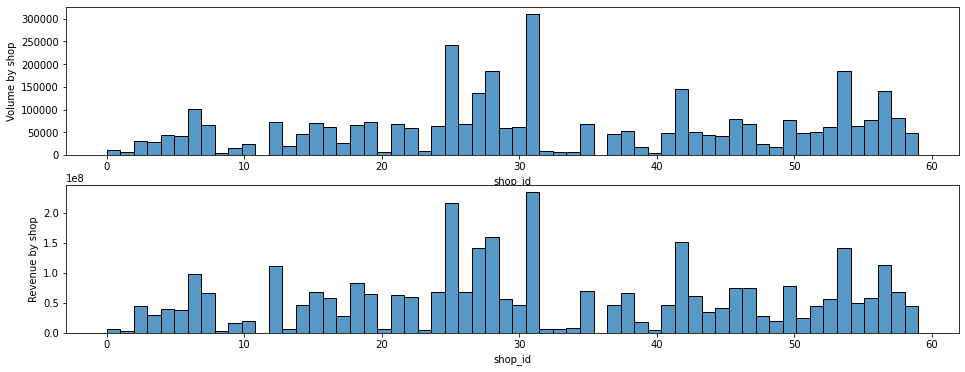

In [6]:
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
sns.histplot(x="shop_id", weights="item_cnt_day", data=sales, bins=shops.shape[0])
plt.ylabel("Volume by shop")
plt.subplot(2,1,2)
sns.histplot(x="shop_id", weights="item_rev_day", data=sales, bins=shops.shape[0])
plt.ylabel("Revenue by shop")

<AxesSubplot:ylabel='item_cnt_day'>

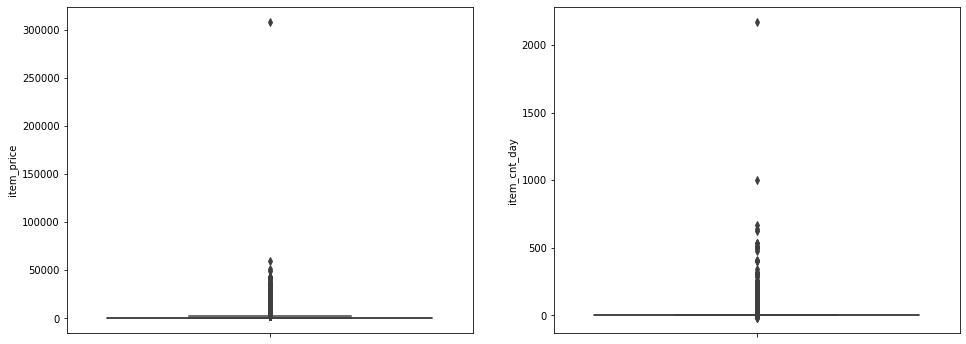

In [7]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(y="item_price", data=sales)
plt.subplot(1,2,2)
sns.boxplot(y="item_cnt_day", data=sales)

In [101]:
print(sales.loc[sales.item_price>200000, "item_id"])
sales.loc[sales.item_id == 6066]# only one in the data set!

1163158    6066
Name: item_id, dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_rev_day
1163158,2013-12-13,11,12,6066,307980.0,1.0,13,12,2013,307980.0


In [111]:
test.loc[test.item_id == 6066] # safe to remove as it does not need to be predicted

,ID,shop_id,item_id


In [ ]:
sales = sales.drop(index=1163158)

In [155]:
sales.loc[sales.item_price < 0]# looks like an NA value

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_rev_day
484683,2013-05-15,4,32,2973,-1.0,1.0,15,5,2013,-1.0


In [159]:
sales.loc[(sales.item_id == 2973) & (sales.date.isin(["2013-05-15", "2013-05-16", "2013-05-14"]))]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_rev_day
442084,2013-05-16,4,28,2973,1249.0,1.0,16,5,2013,1249.0
453034,2013-05-15,4,25,2973,1249.5,1.0,15,5,2013,1249.5
453035,2013-05-14,4,25,2973,1249.1,2.0,14,5,2013,2498.2
456795,2013-05-14,4,21,2973,1249.0,1.0,14,5,2013,1249.0
463473,2013-05-14,4,41,2973,1249.0,1.0,14,5,2013,1249.0
465054,2013-05-16,4,44,2973,1249.0,1.0,16,5,2013,1249.0
469026,2013-05-15,4,46,2973,1249.5,1.0,15,5,2013,1249.5
469951,2013-05-15,4,45,2973,1249.0,1.0,15,5,2013,1249.0
473481,2013-05-14,4,42,2973,1249.0,1.0,14,5,2013,1249.0
480577,2013-05-14,4,35,2973,1249.5,1.0,14,5,2013,1249.5


In [127]:
print(sales.loc[sales.item_cnt_day > 1500])
sales.loc[sales.item_id == 11373]# many sales, at hugely different prices, all in the same shop

              date  date_block_num  shop_id  item_id  item_price  \
2909818 2015-10-28              33       12    11373    0.908714   

         item_cnt_day  day  month  year  item_rev_day  
2909818        2169.0   28     10  2015        1971.0  


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_rev_day
58323,2013-01-08,0,12,11373,1000.00,1.0,8,1,2013,1000.0
58324,2013-01-31,0,12,11373,97.80,5.0,31,1,2013,489.0
176790,2013-02-01,1,12,11373,229.00,1.0,1,2,2013,229.0
176791,2013-02-04,1,12,11373,130.00,1.0,4,2,2013,130.0
302468,2013-03-29,2,12,11373,139.50,2.0,29,3,2013,279.0
...,...,...,...,...,...,...,...,...,...,...
2909829,2015-10-07,33,12,11373,855.00,2.0,7,10,2015,1710.0
2909830,2015-10-06,33,12,11373,208.80,5.0,6,10,2015,1044.0
2909831,2015-10-05,33,12,11373,140.75,16.0,5,10,2015,2252.0
2909832,2015-10-02,33,12,11373,648.50,2.0,2,10,2015,1297.0


## 2. Evolution through time of various quantities

### Aggregate count & revenue across all shops and items

Text(0, 0.5, 'monthly rev.')

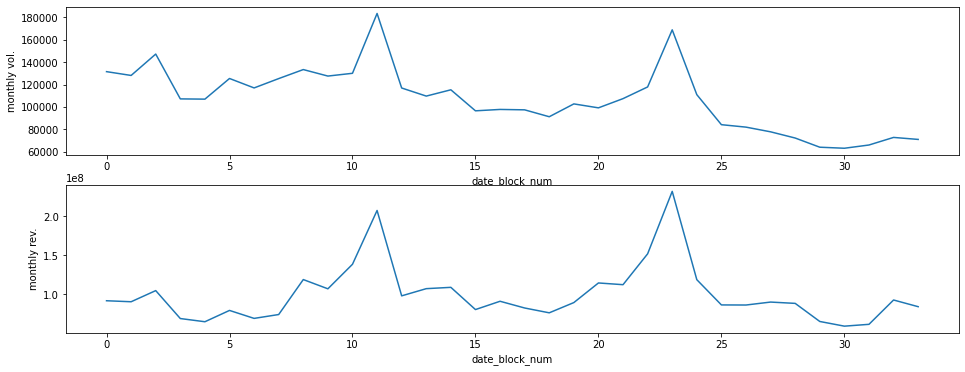

In [8]:
sales_global_m = sales.groupby("date_block_num", as_index=False).item_cnt_day.sum()
revenue_global_m = sales.groupby("date_block_num", as_index=False).item_rev_day.sum()

plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
sns.lineplot(x="date_block_num", y="item_cnt_day", data=sales_global_m)
plt.ylabel("monthly vol.")

plt.subplot(2,1,2)
sns.lineplot(x="date_block_num", y="item_rev_day", data=revenue_global_m)
plt.ylabel("monthly rev.")

### Aggregate count & revenue across shops

Text(0, 0.5, 'monthly revenue')

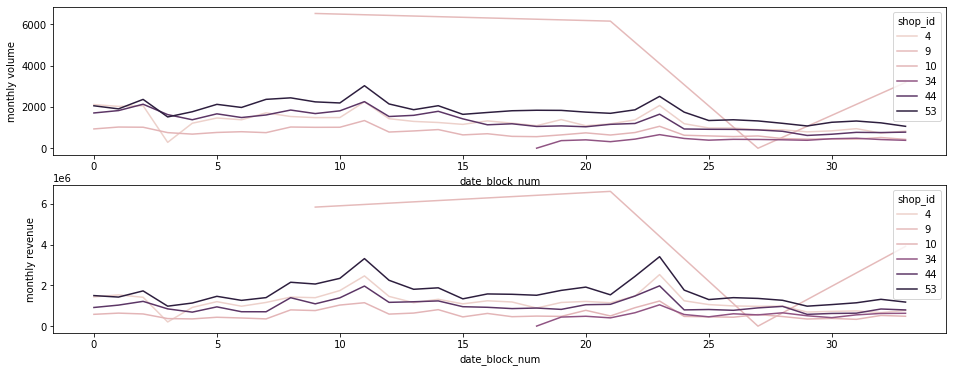

In [10]:
rnd_id = random.sample(list(range(shops.shape[0])), 6)

sales_subset = sales.loc[sales.shop_id.isin(rnd_id)]
sales_shop_m = sales_subset.groupby(["date_block_num", "shop_id"], as_index=False).agg({"item_cnt_day": "sum"})
rev_shop_m = sales_subset.groupby(["date_block_num", "shop_id"], as_index=False).agg({"item_rev_day": "sum"})

plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
sns.lineplot(x="date_block_num", y="item_cnt_day", data=sales_shop_m, hue="shop_id")
plt.ylabel("monthly volume")

plt.subplot(2,1,2)
sns.lineplot(x="date_block_num", y="item_rev_day", data=rev_shop_m, hue="shop_id")
plt.ylabel("monthly revenue")

### Aggregate count & revenue across items

[]

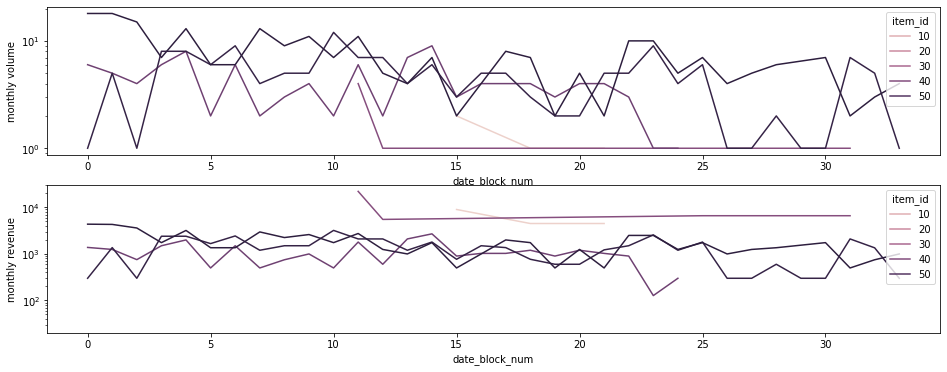

In [11]:
rnd_id = random.sample(list(range(shops.shape[0])), 10)

sales_subset = sales.loc[sales.item_id.isin(rnd_id)]
sales_item_m = sales_subset.groupby(["date_block_num", "item_id"], as_index=False).agg({"item_cnt_day": "sum"})
rev_item_m = sales_subset.groupby(["date_block_num", "item_id"], as_index=False).agg({"item_rev_day": "sum"})

plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
sns.lineplot(x="date_block_num", y="item_cnt_day", data=sales_item_m, hue="item_id")
plt.ylabel("monthly volume")
plt.semilogy()

plt.subplot(2,1,2)
sns.lineplot(x="date_block_num", y="item_rev_day", data=rev_item_m, hue="item_id")
plt.ylabel("monthly revenue")
plt.semilogy()

## 2. Text data

### Shop names

In [138]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Shops with ID's 10 and 11 have the same name up to a typo in the last character.

Using deepl.com we try and get a grasp of those names.

Yakutsk Ordzhonikidze 56 francs

Yakutsk TC "Central" franc

Adygeya shopping centre Mega

Balashikha Shopping and Entertainment Centre "OktyabrKinomir".

Volga Mall Volga shopping centre

Vologda Marmelad Shopping and Entertainment Centre

...

Kazan Park House II shopping centre

Kaluga XXI Century Shopping and Entertainment Centre

Kolomna shopping centre "Rio"

Krasnoyarsk Vzletka Plaza shopping centre

Krasnoyarsk June shopping centre

...

Moscow New Century shopping centre (Novokosino)

Moscow Perlovsky shopping centre

Moscow Semyonovsky shopping centre

Moscow Silver House shopping centre

...

St. Petersburg Trade Company Nevsky Center

SPb ТC Sennaya

...

Yakutsk Ordzhonikidze 56

Yakutsk TC Tsentralny

Yaroslavl Altair shopping centre

_Translated with www.DeepL.com/Translator (free version)_

First word is the city. Shops in Yakutsk seem to be duplicated, i.e., 0 is also 57 and 1 is also 58. Similarly, two occurences of the Megacentre "Horizon" in Rostov-on-Don are listed at rows 39 and 40.

### Category names

In [146]:
item_cat

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


Using deepl.com again to get some insights...

PC - Headsets / Headphones

Accessories - PS2

Accessories - PS3

Accessories - PS4

Accessories - PSP
 
...

Books - Audiobooks

Books - Audiobooks (Number)

Books - Audiobooks 1C

Books - Business literature

Books - Manga Comics

...

Programmes - For home and office (Number)

Programmes - Trainers

Programmes - Training (Number)

Service .

Service - Tickets

Clean media (spire)

Clean media (piece by piece)

Batteries

_Translated with www.DeepL.com/Translator (free version)_

The first bit before the dash defines a meta-category, the second bit a sub-category.

## Item names

In [8]:
print(items.columns)
print(items.shape[0])
items.loc[:, ["item_name"]].drop_duplicates()

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
22170


,item_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
1,!ABBYY FineReader 12 Professional Edition Full...
2,***В ЛУЧАХ СЛАВЫ (UNV) D
3,***ГОЛУБАЯ ВОЛНА (Univ) D
4,***КОРОБКА (СТЕКЛО) D
...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]"
22166,Язык запросов 1С:Предприятия [Цифровая версия]
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...
22168,Яйцо для Little Inu


No duplicates in raw item names. Now try and pre-process the text to homogenise formatting.

In [12]:
stemmer = SnowballStemmer(language="russian")
items["item_name_clean"] = items["item_name"].apply(lambda x: x.lower())
items["item_name_clean"] = items["item_name_clean"].apply(lambda x: re.sub(r'\W+',' ',x))
items["item_name_clean"] = items["item_name_clean"].apply(lambda x: re.sub('  ',' ',x))
items["item_name_clean"] = items["item_name_clean"].apply(lambda x: x.strip())
#items["item_name_clean"] = items["item_name_clean"].apply(lambda x: stemmer.stem(x))
print(items.shape[0] - items.item_name_clean.drop_duplicates().shape[0])
items.tail(20)

90


,item_name,item_id,item_category_id,item_name_clean
22150,Я-ЧЕТВЕРТЫЙ (BD),22150,37,я четвертый bd
22151,ЯВЛЕНИЕ (2012),22151,40,явление 2012
22152,ЯВЛЕНИЕ (2012) (регион),22152,40,явление 2012 регион
22153,ЯВЛЕНИЕ (BD),22153,37,явление bd
22154,ЯВЛЕНИЕ 2012 (BD),22154,37,явление 2012 bd
22155,"ЯДЫ, ИЛИ ВСЕМИРНАЯ ИСТОРИЯ ОТРАВЛЕНИЙ (BD)",22155,37,яды или всемирная история отравлений bd
22156,"ЯДЫ, ИЛИ ВСЕМИРНАЯ ИСТОРИЯ ОТРАВЛЕНИЙ (регион)",22156,40,яды или всемирная история отравлений регион
22157,ЯЛТА 45,22157,40,ялта 45
22158,ЯМА (rem),22158,40,яма rem
22159,ЯНКОВСКИЙ,22159,40,янковский


Adding the stemming step only removes 5 duplicates at the cost of transforming Latin characters to Cyrillic characters. Given the amount of text data here, a good automised approach will be to use TF-IDF to extract information.